In [1]:
import sys
import os
import matplotlib.pyplot as plt 


sys.path.append(os.path.abspath('../src'))

In [2]:
from networks import run_single_network, create_random_network
from utils import plot_raster, plot_adjacency_matrix


In [3]:
neurons, G = create_random_network(N=500, p_connect=0.1, weight_bounds=(0.1,5))

In [4]:
T_seconds = 1 

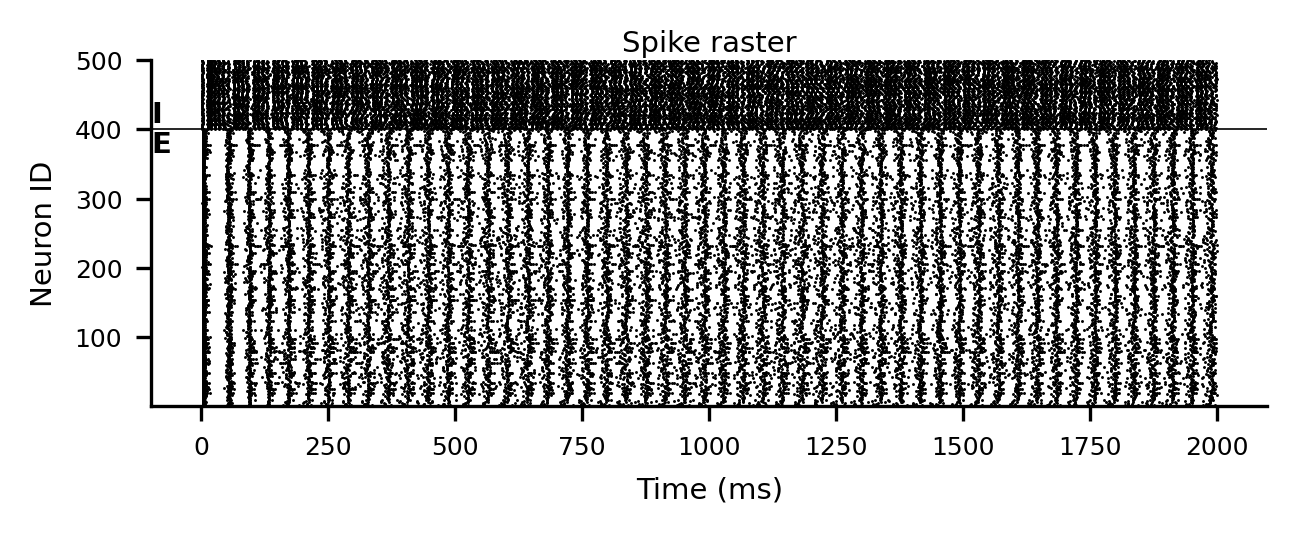

In [5]:
T =int( T_seconds* 2000)
V_hist, S_hist, I_syn_hist, I_ext, final_state, final_stdp_state = run_single_network(
    neurons, G, network_type='stdp_syn', T=T, nkey=32)
plot_raster(S_hist, neurons, final_state.W, T_total=T)
plt.show()

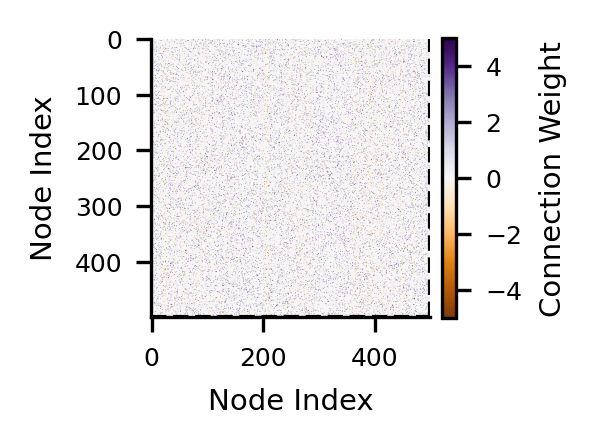

In [6]:
plot_adjacency_matrix(G, figsize=(2,2))
plt.show()

In [7]:
import infomeasure as im
import antropy as ant
import numpy as np 
from tqdm import tqdm 

In [8]:
im_args = {"approach": "miller_madow", "base": 2}


In [64]:
A = np.array(S_hist)
A.shape

(8000, 500)

In [65]:
im.entropy(A, **im_args)

np.float64(13.433150499718995)

100%|██████████| 2001/2001 [02:10<00:00, 15.29it/s]


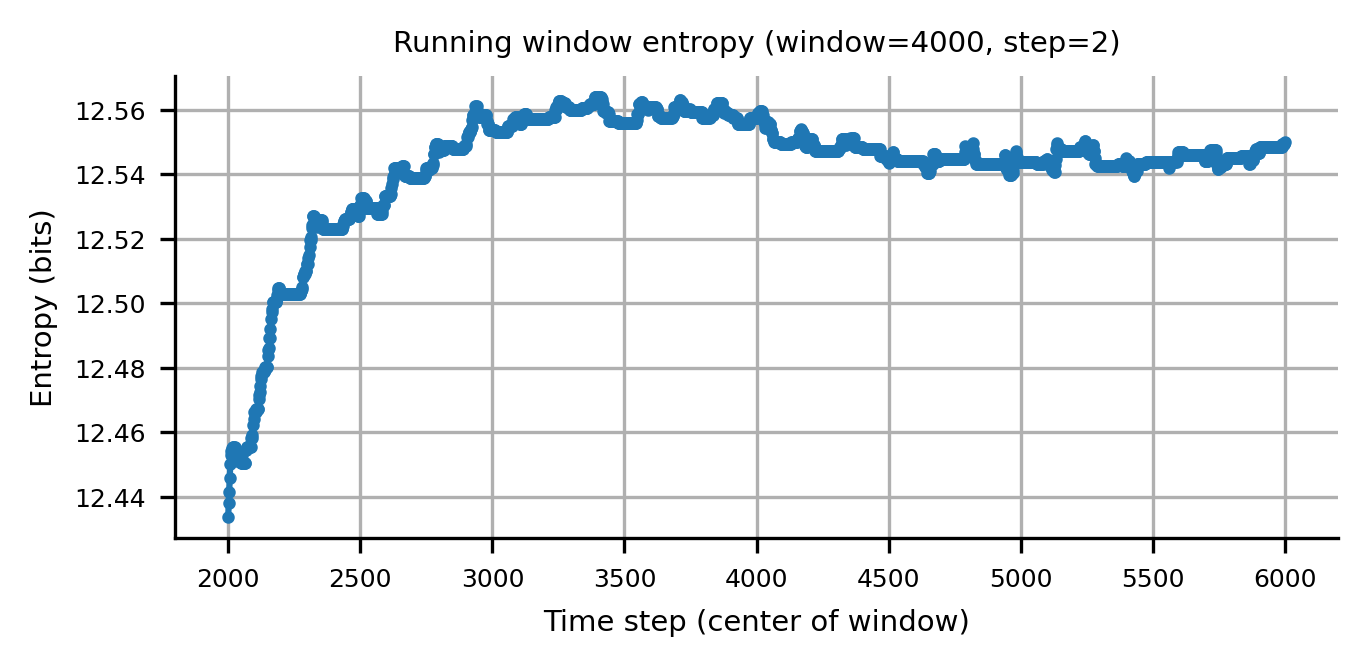

In [67]:
# Running window entropy
window_size = int(1000/0.25)
step_size = 2

entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A[start:start+window_size]
    H = im.entropy(window, **im_args)
    entropies.append(H)
    times.append(start + window_size//2)

# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=2)
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.show()

In [12]:
def add_noise_in_window(A, a, b, p=0.01, seed=None):
    """
    Add noise to binary spike matrix A within timesteps [a, b).
    
    """
    rng = np.random.default_rng(seed)
    A_noisy = A.copy()
    
    mask = rng.random(size=A_noisy[a:b].shape) < p
    A_noisy[a:b][mask] = 1 - A_noisy[a:b][mask]
    
    return A_noisy

In [62]:
array_test = A
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(1.4664512469448783)

In [50]:
A_noisy = add_noise_in_window(A, 4000, 5000)

100%|██████████| 797/797 [00:00<00:00, 1097.53it/s]


ValueError: x and y must have same first dimension, but have shapes (797,) and (601,)

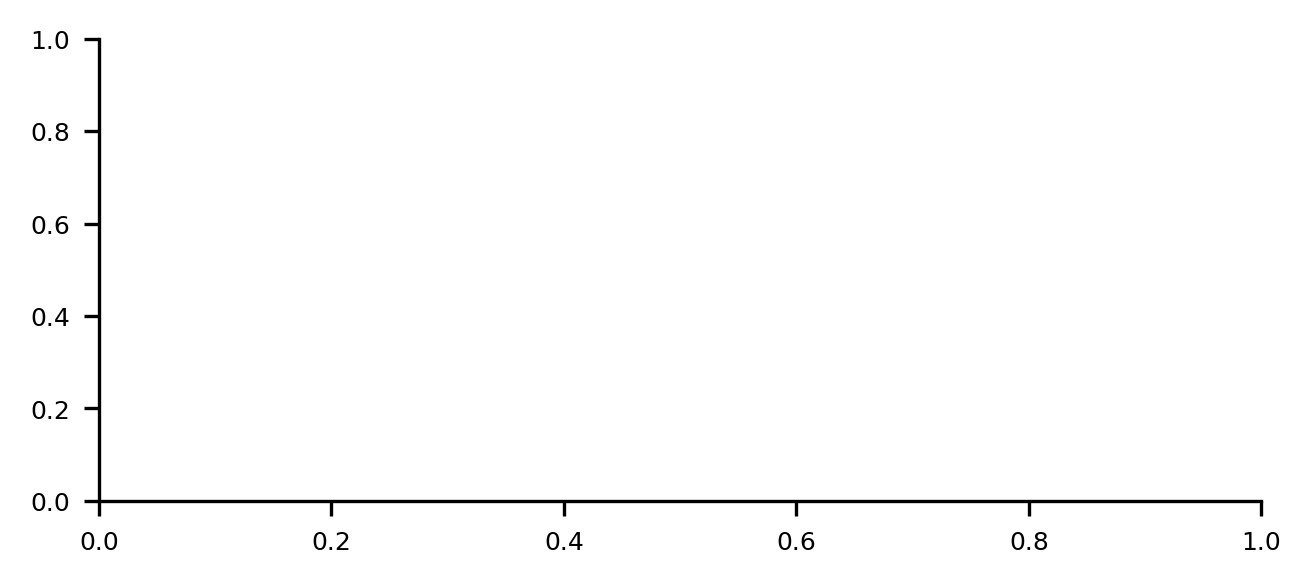

In [63]:
# Running window entropy
window_size = int(10/0.25)
step_size = 10

n_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_noisy[start:start+window_size]
    H = im.entropy(window, **im_args)
    n_entropies.append(H)
    times.append(start + window_size//2)

# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=2)
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.show()

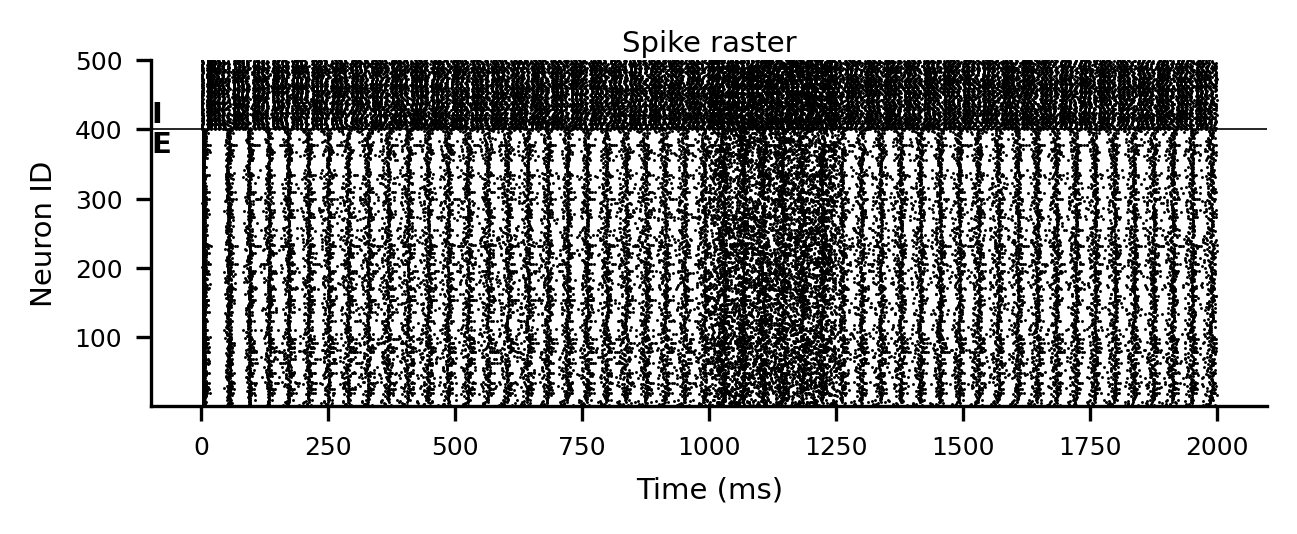

In [15]:
plot_raster(A_noisy, neurons, final_state.W, T_total=T)
plt.show()

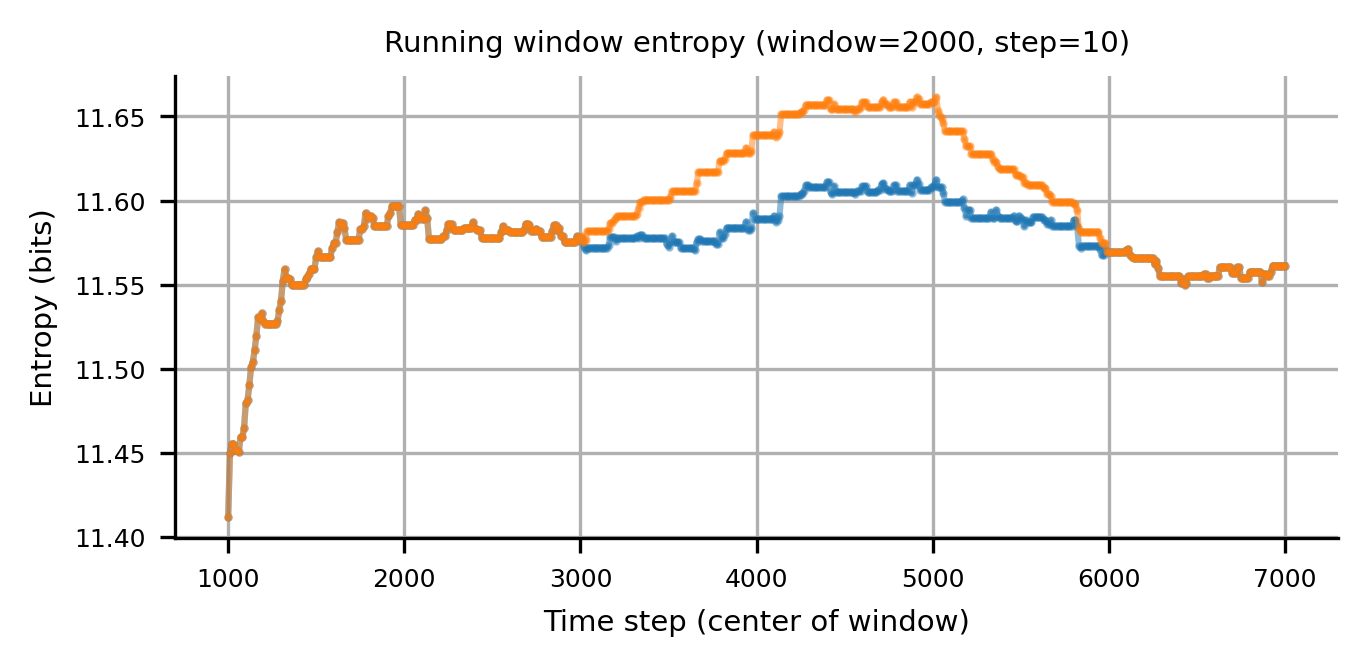

In [16]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1, alpha=0.5)
plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5)
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.show()

In [54]:
array_test = A_noisy
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(1.1730112734075921)

In [17]:
def add_structured_noise(A, a, b, mode="silence", p=0.2, seed=None):

    rng = np.random.default_rng(seed)
    A_noisy = A.copy()
    segment = A_noisy[a:b]

    if mode == "silence":
        mask = (segment == 1) & (rng.random(segment.shape) < p)
        segment[mask] = 0
    elif mode == "burst":
        mask = (segment == 0) & (rng.random(segment.shape) < p)
        segment[mask] = 1
    else:
        raise ValueError("mode must be 'silence' or 'burst'")

    A_noisy[a:b] = segment
    return A_noisy



In [55]:
A_silenced = add_structured_noise(A, 4000, 5000)

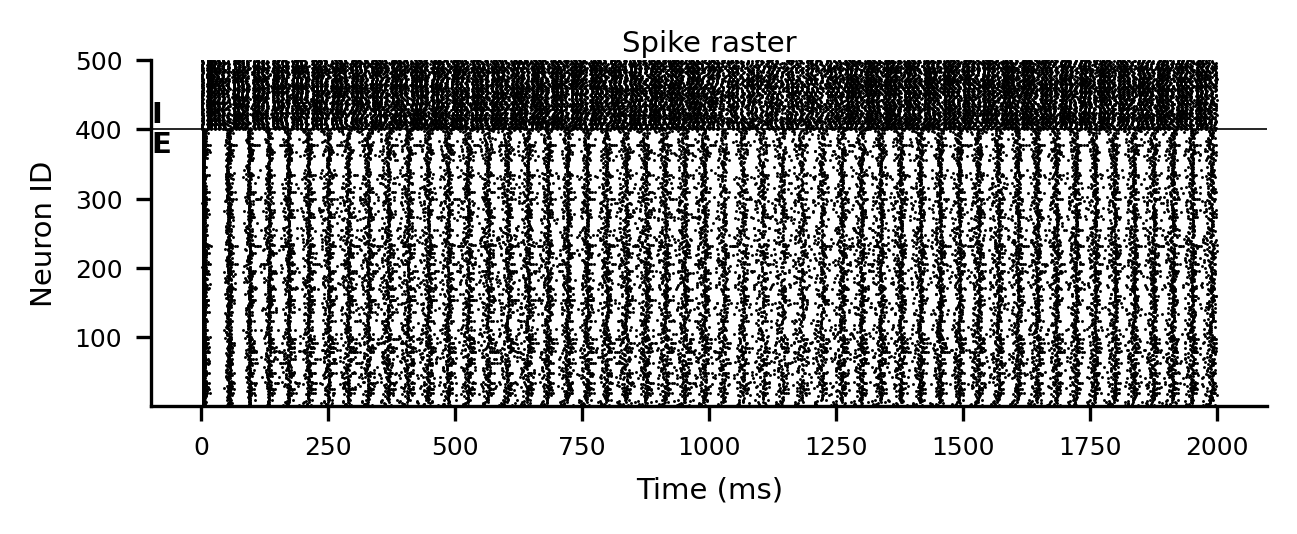

In [19]:
plot_raster(A_silenced, neurons, final_state.W, T_total=T)
plt.show()

In [20]:
# Running window entropy
window_size = int(500/0.25)
step_size = 10

s_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_silenced[start:start+window_size]
    H = im.entropy(window, **im_args)
    s_entropies.append(H)
    times.append(start + window_size//2)



100%|██████████| 601/601 [00:18<00:00, 33.32it/s]


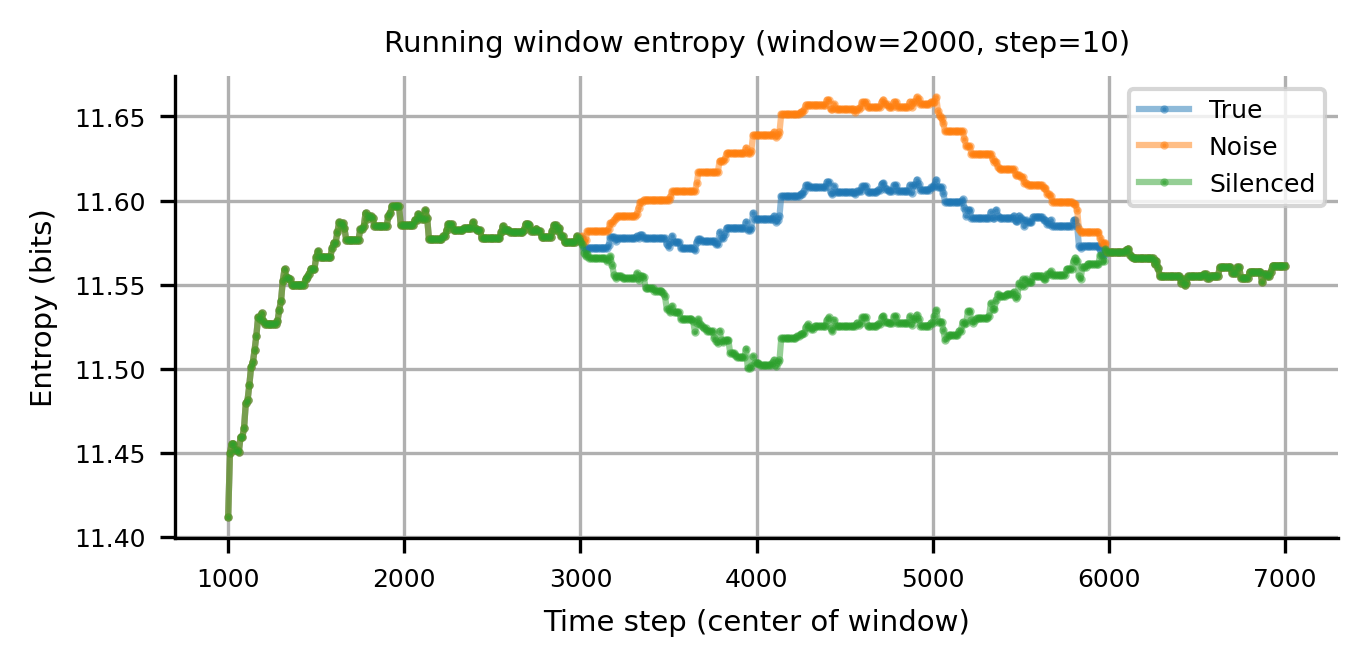

In [21]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1,  alpha=0.5, label='True')
plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5, label='Noise')
plt.plot(times, s_entropies, marker='o', markersize=1, alpha=0.5, label='Silenced')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.legend()
plt.show()

In [56]:
array_test = A_silenced
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(0.6275556156720316)

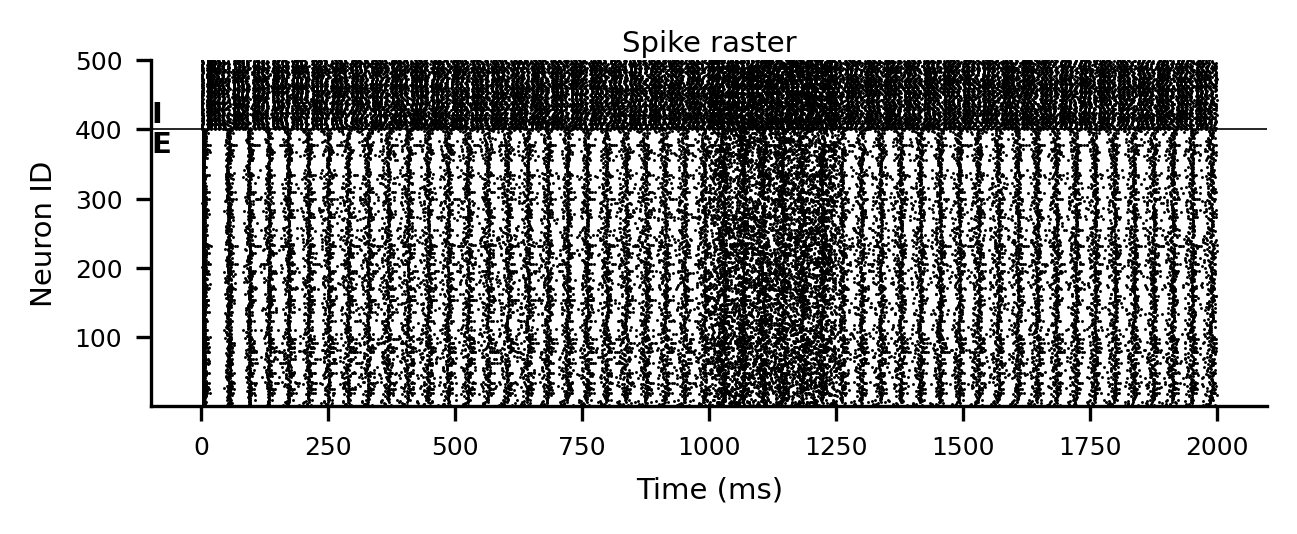

In [23]:
plot_raster(A_noisy, neurons, final_state.W, T_total=T)
plt.show()

In [78]:
import jax

In [81]:
jax.devices("cpu")[0]

CpuDevice(id=0)

In [57]:
# Silence for ever
A_silenced = add_structured_noise(A, 4000, 8000)

In [25]:
# Running window entropy
window_size = int(500/0.25)
step_size = 10

s_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_silenced[start:start+window_size]
    H = im.entropy(window, **im_args)
    s_entropies.append(H)
    times.append(start + window_size//2)



100%|██████████| 601/601 [00:19<00:00, 31.41it/s]


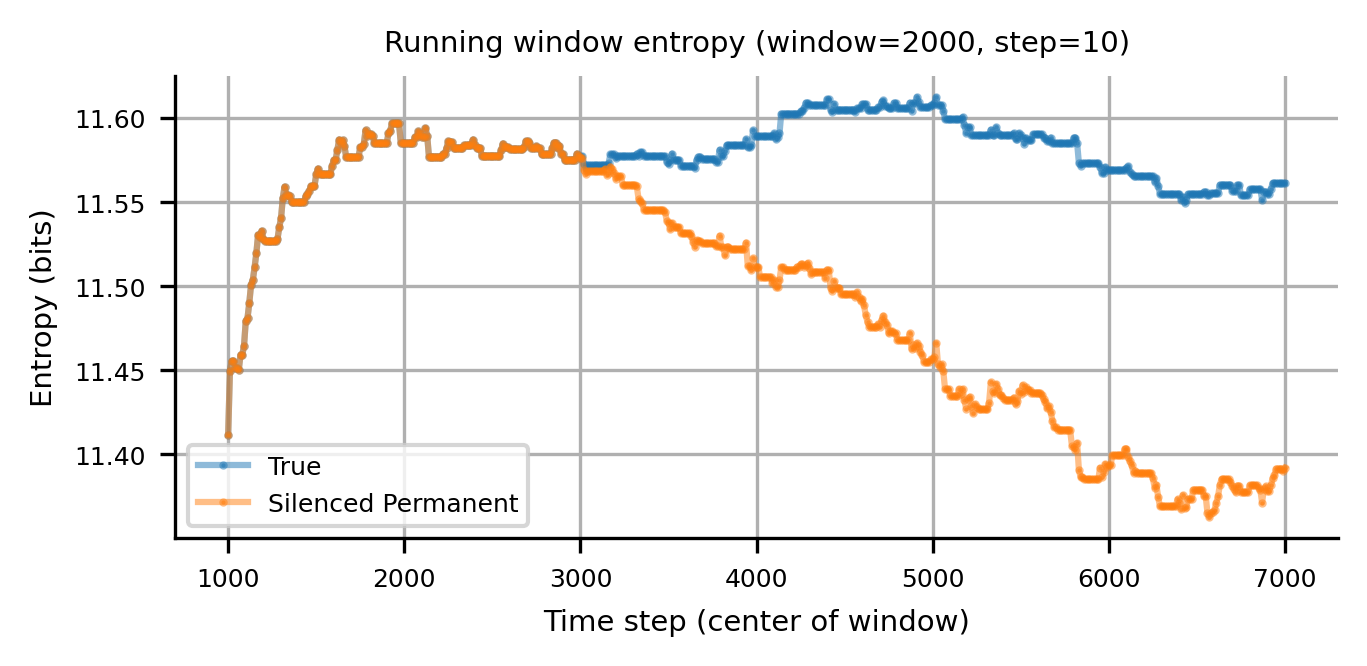

In [28]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1,  alpha=0.5, label='True')
#plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5, label='Noise')
plt.plot(times, s_entropies, marker='o', markersize=1, alpha=0.5, label='Silenced Permanent')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.legend()
plt.show()

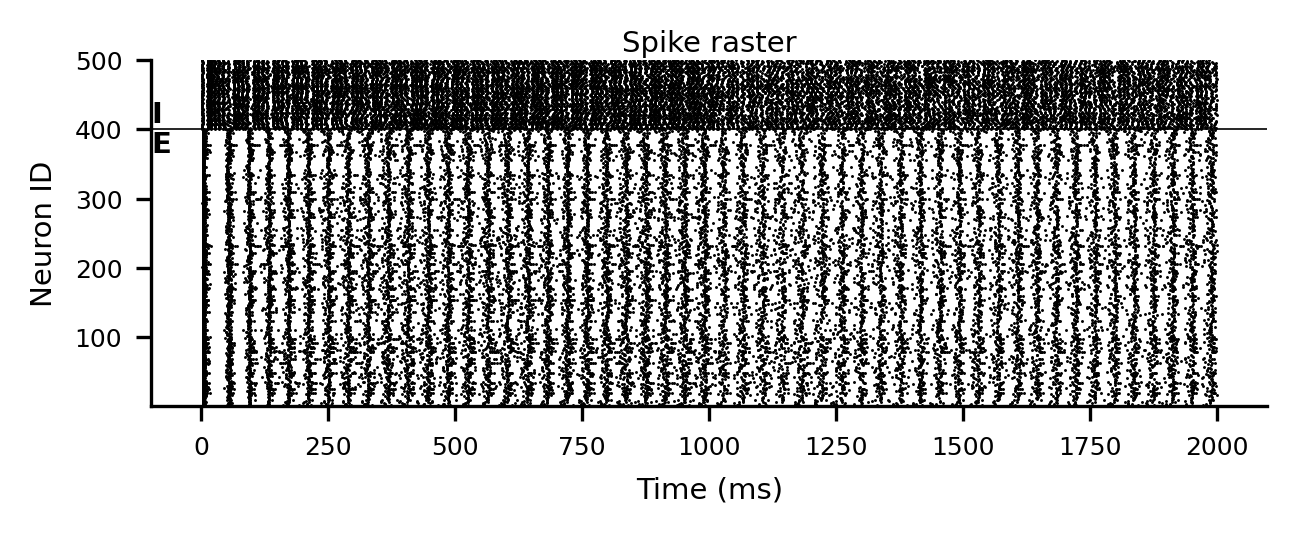

In [29]:
plot_raster(A_silenced, neurons, final_state.W, T_total=T)
plt.show()

In [58]:
array_test = A_silenced
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(-0.2959106596908949)

In [59]:
# Permantent noise
A_noisy = add_noise_in_window(A, 4000, 8000)

In [31]:
# Running window entropy
window_size = int(500/0.25)
step_size = 10

n_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_noisy[start:start+window_size]
    H = im.entropy(window, **im_args)
    n_entropies.append(H)
    times.append(start + window_size//2)



100%|██████████| 601/601 [00:14<00:00, 42.14it/s]


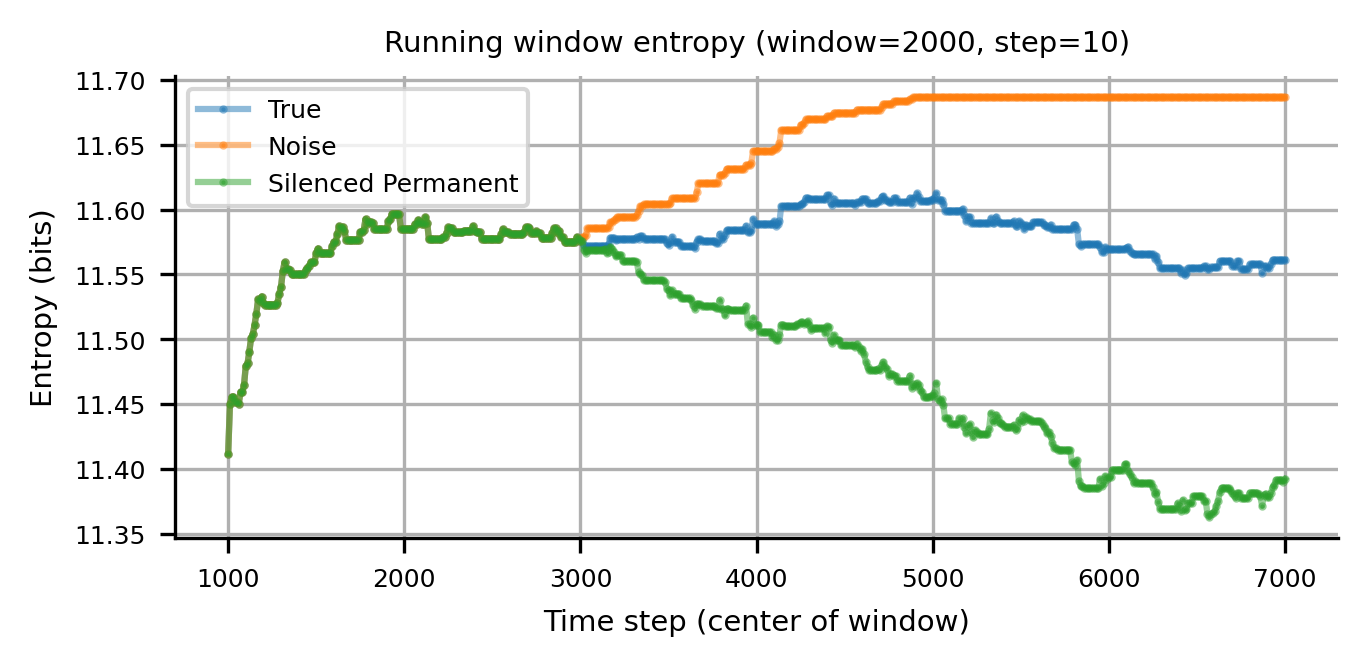

In [32]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1,  alpha=0.5, label='True')
plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5, label='Noise')
plt.plot(times, s_entropies, marker='o', markersize=1, alpha=0.5, label='Silenced Permanent')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.legend()
plt.show()#

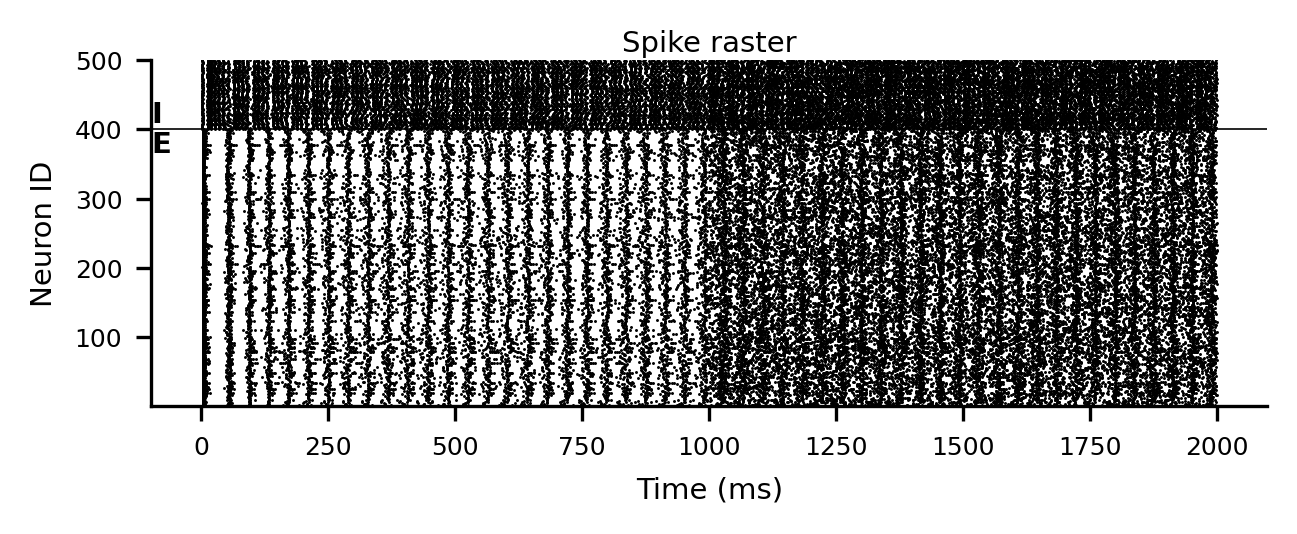

In [33]:
plot_raster(A_noisy, neurons, final_state.W, T_total=T)
plt.show()

In [36]:
n_entropies[3000:4000]

[]

In [60]:
array_test = A_noisy
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(-0.0)

In [61]:
R_H

np.float64(-0.0)

In [ ]:
im.entropy(A_noisy[2000:4000], **im_args)

np.float64(11.576100544419388)

In [44]:
im.entropy(A_noisy[4000:6000], **im_args) 

np.float64(11.686771131346347)

In [45]:
im.entropy(A_noisy[6000:8000], **im_args)

np.float64(11.686771131346347)

In [49]:
A_noisy.shape

(8000, 500)